In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import statsmodels.api as sm
from pandas_datareader import data as pd_data
import laplacejumps as lj
import shelve
from scipy import special
from dask import bag as db
from dask.diagnostics import ProgressBar
from bayesiankalman import mcmc
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib import cm as mat_cm

In [2]:
%matplotlib inline
mpl.pyplot.style.use('seaborn-talk')
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.rc('text', usetex=True, **{'latex.preamble' : [r'\usepackage{mathtools}', r'\usepackage{amsmath}',
                                                   r'\usepackage[cm]{sfmath}', r'\usepackage{xcolor}']})
presentation_fontsize=22
mpl.rc('font', **{'family':'sans-serif', 'sans-serif':'cm'})
mpl.rc('legend', **{'fontsize':presentation_fontsize})
mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
mpl.rc('xtick', **{'labelsize':presentation_fontsize})
mpl.rc('ytick', **{'labelsize': presentation_fontsize})

In [3]:
with pd.HDFStore('../results/spy_5min_vol_estimates_2003-2017.hdf', mode='r') as volatility_store:
    real_vol = volatility_store['real_vol']
    bipower11_vol = volatility_store['bipower11_vol']
    bipower_jump_vol = volatility_store['bipower_jump_vol']

In [4]:
with pd.HDFStore('../results/spy_volatility_estimates_2003-2017.hdf', mode='r') as volatility_store:
    discrete_vol = volatility_store['discrete_vol_est']
    daily_rtn = volatility_store['daily_rtn'][discrete_vol.dropna().index]
    discrete_vol = volatility_store['discrete_trunc_vol']
    bipower_vol = volatility_store['bipower_vol']

In [5]:
discrete_vol['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
discrete_vol['real_vol'] = real_vol

log_vol = (252 * discrete_vol).apply(np.log).dropna()
log_vol['excess_rtn'] = daily_rtn
log_vol['weights'] = log_vol['quad'].apply(np.exp)**(-1)
log_vol.dropna(inplace=True)
log_vol['weights'] = log_vol.weights
log_vol['log_prop'] = special.logit(np.exp(log_vol.jumps - log_vol.quad))


In [6]:
treasury_yield = pd_data.get_data_fred('DGS10', start='1950', end='2018').apply(
    lambda x: np.log(x/(100 * 365) + 1)).rename(columns={'DGS10':'log_yield'})
daily_rtn = np.sqrt(252) * (daily_rtn - treasury_yield.T).T.rename(columns={'log_yield':'daily_rtn'}).dropna()

In [7]:
with shelve.DbfilenameShelf('../results/rolling_model_estimates_boller2009', protocol=4) as database:
    models = [(key,val) for key,val in database.items()]  

In [8]:
len(models)

1900

In [9]:
nsims = int(1e3)
# percentiles = [.5, 2.5, 12.5, 25 ,50, 75, 87.5, 97.5, 99.5]
horizon=1
numlags = 50
alpha_for_ci = .95

In [10]:
percentiles = [0.05, 0.5, 2.5, 12.5, 25, 37.5, 50, 62.5, 75, 87.5, 97.5, 99.5, 0.05]
labels = ['Median', '99.9\%', '99\%', '95\%', '75\%', '50\%', '25\%']

## Create the HAR forecasts

In [11]:
def density_forecast(date, model, horizon):
    n = log_vol.index.get_loc(date)
    true_in = log_vol['excess_rtn'].iloc[n+1:n+horizon+1]
    forecasts = model.density_predict(H=horizon, forecast_dim=int(1e4))
    
    forecast_df = pd.DataFrame(forecasts)
    forecast_df.index = true_in.index
    columns = range(int(1e4))
    
    return forecast_df.iloc[horizon-1]

In [12]:
def extract_forecasts(estimate, density_func, horizon):
    """ 
    Takes an estimate and converts it into a properly structured density forecast
    Parameters
    ---------
    estimate: 2-element tuple
    loss_func : function
    **kwargs : passed to loss_func
    Returns
    ------
    tree of dataframes
    """
    results_in = lj.tree()
    key, model = estimate

    vol_name, regressors, regressand, date = key.split('/')
    resid = density_func(date=date, model=model, horizon=horizon)
    results_in[vol_name][regressand][regressors][date] = pd.DataFrame(resid)
    
    return results_in



In [13]:
def reorganize_results(iterable):
    """
    Reorganizes the results as computed using the extract_results function a bunch of times into a nested
    dictionary.
    """
    
    iterable = lj.nested_dict_merge(iterable)
    results_out = lj.tree()
    for vol_name, vol_data in iterable.items():
        for regressand, regressand_data in vol_data.items():
            for regressor, regressor_data in regressand_data.items():

                data = pd.concat(list(regressor_data.values()), axis=1).T

                results_out[vol_name][regressand][regressor] = data
    return results_out


In [14]:
bag2 = db.from_sequence(models)
with ProgressBar():
    results = reorganize_results(bag2.map(extract_forecasts, density_func=density_forecast, 
                                          horizon=horizon).compute())

[########################################] | 100% Completed | 40.2s


In [15]:
rxt_ar_forecast = results['Log Volatility']['\\rxt']['BP-J-\\rxt']

In [16]:
rxt_var_forecast = results['Log Volatility']['\\lbrack \\rxt, $\\log(\\jumppropt)$, \\totalvolt \\rbrack']['AR(1)-\\totalvolt--$\\log(\\jumppropt)$']

In [17]:
rxt_ar_forecast = results['Log Volatility']['\\lbrack \\rxt, $\\log(\\jumppropt)$, \\totalvolt \\rbrack'][ 'HAR-\\totalvolt']

In [19]:
rxt_ar_forecast

defaultdict(<function laplacejumps.har_model.tree()>, {})

In [18]:
ar_forecast_merged = pd.concat([daily_rtn, rxt_ar_forecast], axis=1).dropna()

TypeError: cannot concatenate object of type "<class 'collections.defaultdict'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [ ]:
var_forecast_merged = pd.concat([daily_rtn, rxt_var_forecast], axis=1).dropna()

## Var Forecast Evaluation

In [ ]:
var_har_pit = mcmc.probability_integral_transform(reference_data=var_forecast_merged.iloc[:,1:], 
                                              evaluated_data=var_forecast_merged['daily_rtn'])

In [ ]:
ar_har_pit = mcmc.probability_integral_transform(reference_data=ar_forecast_merged.iloc[:,1:], 
                                              evaluated_data=ar_forecast_merged['daily_rtn'])

## Plots

In [ ]:
var_forecast_fig, var_forecast_ax = mpl.pyplot.subplots()
var_forecast_ax.plot(var_forecast_merged['daily_rtn'].resample('D').last().dropna(), color='purple', zorder=20,
                    label='$r_t$')
mcmc.fan_plot(ax=var_forecast_ax, data=var_forecast_merged.iloc[:,1:], percentiles=percentiles,
                          cm=mat_cm.get_cmap('gist_rainbow'), labels=labels)
var_forecast_ax.set_ylim([-3, 3])
var_forecast_ax.xaxis.set_major_locator(mdates.YearLocator())
var_forecast_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
var_forecast_ax.legend(ncol=2, loc='lower right')

var_forecast_fig.savefig('../doc/figures/ar_tv_lp_forecast.tmp.pdf', bbox_tight=True, transparent=True,
                         pad_inches=0)

In [ ]:
# From Scott (1979), using Gaussian case. 
opt_var_bins = int(np.round(np.std(var_har_pit)**(-1) * var_har_pit.size**(1/3) / ( 2 * 3**(1/3)  * np.pi**(1/6))) )
var_pit_fig, var_pit_ax = mpl.pyplot.subplots()
sns.distplot(var_har_pit, norm_hist=True, kde=False, ax=var_pit_ax,bins=opt_var_bins, color='green')
var_pit_ax.set_xlim([0,1])
var_pit_ax.set_ylim([0,2])
var_ci_bottom, var_ci_top = stats.binom.interval(alpha=alpha_for_ci, n=var_har_pit.size, p=opt_var_bins**(-1)) 
var_pit_ax.axhline(var_ci_bottom * (opt_var_bins / var_har_pit.size), color='red', linestyle='dashed')
var_pit_ax.axhline(var_ci_top * (opt_var_bins / var_har_pit.size), color='red', linestyle='dashed')
var_pit_ax.axhline(1, color='black')
var_pit_ax.yaxis.set_major_locator(mticker.FixedLocator([0, .5, 1, 1.5, 2]))
var_pit_fig.savefig('../doc/figures/ar_tv_lp_pit_density.tmp.pdf')

In [ ]:
var_xdata = np.linspace(0, 1, var_har_pit.size)
var_forecast_qq_fig, var_forecast_qq_ax = mpl.pyplot.subplots()
var_forecast_qq_ax.scatter(var_xdata, np.sort(np.ravel(var_har_pit)), c='green', marker='.')
var_forecast_qq_ax.plot(var_xdata, var_xdata)
var_forecast_qq_ax.axvline(.5)
var_forecast_qq_ax.yaxis.set_major_locator(mticker.FixedLocator([0, .25, .5, .75, 1]))
var_forecast_qq_fig.savefig('../doc/figures/ar_tv_lp_qq.tmp.pdf')

In [ ]:
var_pit_autocorr_fig, var_pit_autocorr_ax = mpl.pyplot.subplots()
sm.graphics.tsa.plot_acf(var_har_pit, lags=numlags, title="", ax=var_pit_autocorr_ax, zero=False)
var_pit_autocorr_ax.set_ylim([-1,1])
var_pit_autocorr_fig.savefig('../doc/figures/ar_tv_lp_pit_autocorrelation.tmp.pdf', bbox_tight=True,
                            transparent=True, pad_inches=0)

## RV Forecast Evaluation

In [20]:
from matplotlib import cm as mat_cm

NameError: name 'ar_forecast_merged' is not defined

/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning

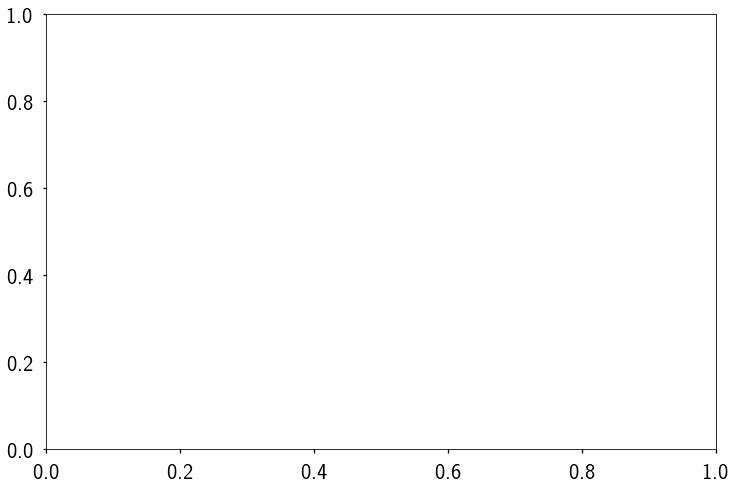

In [21]:
rv_forecast_fig, rv_forecast_ax = mpl.pyplot.subplots()
rv_forecast_fig.set_size_inches((12,8))
rv_forecast_ax.plot(ar_forecast_merged['daily_rtn'], color='purple', label="$r_t$", zorder=20)
mcmc.fan_plot(ax=rv_forecast_ax, data=ar_forecast_merged.iloc[:,1:], percentiles=percentiles,
             cm=mat_cm.get_cmap('gist_rainbow'), labels=labels)
rv_forecast_ax.set_ylim([-3, 3])
rv_forecast_ax.xaxis.set_major_locator(mdates.YearLocator())
rv_forecast_ax.xaxis.set_major_formatter( mdates.DateFormatter('%Y'))
rv_forecast_ax.legend(ncol=2, loc='lower right')
rv_forecast_fig.savefig('../doc/figures/total_vol_forecast.tmp.pdf', bbox_tight=True, transparent=True, 
                        pad_inches=0)

In [ ]:
opt_rv_bins = int(np.round(np.std(ar_har_pit)**(-1) * ar_har_pit.size**(1/3) / ( 2 * 3**(1/3)  * np.pi**(1/6))) )
rv_pit_ax = sns.distplot(ar_har_pit, kde=False, norm_hist=True, bins=opt_rv_bins, color='green')
rv_ci_bottom, rv_ci_top = stats.binom.interval(alpha=alpha_for_ci, n=ar_har_pit.size, p=opt_rv_bins**(-1))
rv_pit_ax.axhline(rv_ci_bottom * (opt_rv_bins/ ar_har_pit.size), color='red', linestyle='dashed')
rv_pit_ax.axhline(rv_ci_top * (opt_rv_bins / ar_har_pit.size), color='red', linestyle='dashed')
rv_pit_ax.axhline(1, color='black')
rv_pit_ax.set_xlim([0,1])
rv_pit_ax.set_ylim([0,2])

NameError: name 'ar_har_pit' is not defined

/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning

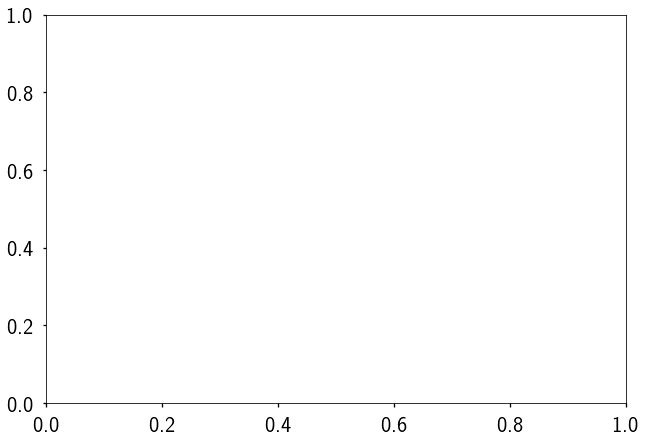

In [22]:
rv_pit_autocorr_fig, rv_pit_autocorr_ax = mpl.pyplot.subplots()
sm.graphics.tsa.plot_acf(ar_har_pit, lags=numlags, title="", ax=rv_pit_autocorr_ax, zero=False)
rv_pit_autocorr_ax.set_ylim([-1,1])
rv_pit_autocorr_fig.savefig('../doc/figures/har_tv_pit_autocorrelation.tmp.pdf', bbox_tight=True,
                           transparent=True, pad_inches=0)

In [ ]:
ar_xdata = np.linspace(0, 1, ar_har_pit.size)
ar_forecast_qq_fig, ar_forecast_qq_ax = mpl.pyplot.subplots()
ar_forecast_qq_ax.scatter(ar_xdata, np.sort(np.ravel(ar_har_pit)), c='green', marker='.')
ar_forecast_qq_ax.plot(ar_xdata, ar_xdata)
ar_forecast_qq_ax.axvline(.5)
ar_forecast_qq_ax.xaxis.set_major_locator(mticker.FixedLocator([0, .25, .5, .75, 1]))
ar_forecast_qq_ax.yaxis.set_major_locator(mticker.FixedLocator([0, .25, .5, .75, 1]))
ar_forecast_qq_fig.savefig('../doc/figures/boller2009_qq.tmp.pdf', bbox_tight=True,
                           transparent=True, pad_inches=0)

## Forecast Comparison

In [23]:
rv_forecast_log_like_points = mcmc.forecast_likelihood_evaluation(rv_forecast_comparison.iloc[:,1:],
                                                             rv_forecast_comparison['daily_rtn'])

NameError: name 'rv_forecast_comparison' is not defined

In [24]:
var_forecast_log_like_points = mcmc.forecast_likelihood_evaluation(var_forecast, var_forecast_merged['daily_rtn'])

NameError: name 'var_forecast' is not defined

The approximate percent better we are doing on average. Since I am comparing the log-likelhood values, higher is better.

In [25]:
var_forecast_log_like_points

NameError: name 'var_forecast_log_like_points' is not defined

In [26]:
rv_forecast_log_like_points

NameError: name 'rv_forecast_log_like_points' is not defined

In [27]:
(var_forecast_log_like_points - rv_forecast_log_like_points) * 100

NameError: name 'var_forecast_log_like_points' is not defined

In [28]:
unif_cdf_vals = np.linspace(0,1, np.minimum(var_pit.size, rv_pit.size))

NameError: name 'var_pit' is not defined

NameError: name 'unif_cdf_vals' is not defined

/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sangrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning

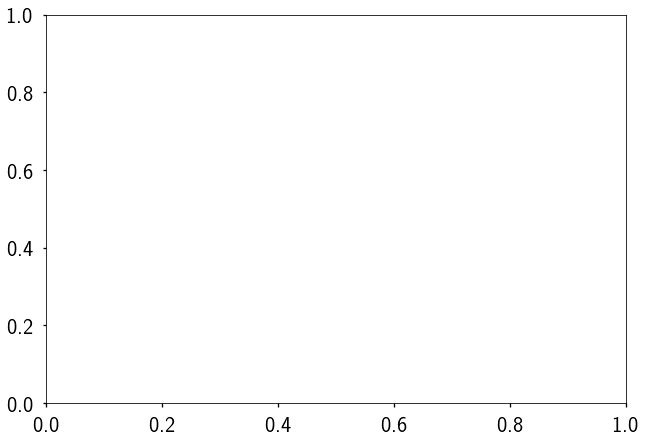

In [29]:
pit_comp_fig, pit_comp_ax = mpl.pyplot.subplots()
pit_comp_ax.plot(unif_cdf_vals, label='Ideal')
pit_comp_ax.plot(np.sort(var_pit.values[-unif_cdf_vals.size:].ravel()), label='Jump-Diffusion Based Forecast')
pit_comp_ax.plot(np.sort(rv_pit.values[-unif_cdf_vals.size:].ravel()), label='Diffusion Based Forecast')
pit_comp_ax.plot(np.abs(np.sort(rv_pit.values.ravel()[-unif_cdf_vals.size:]) - unif_cdf_vals) 
                 - np.abs(np.sort(var_pit.values.ravel()[-unif_cdf_vals.size:]) - unif_cdf_vals),
                 label='Forecast Error Differences', color='red')
pit_comp_ax.axhline(0)
pit_comp_ax.set_xticks(np.asarray(percentiles)[1:-1] * unif_cdf_vals.size / 100)
pit_comp_ax.set_xticklabels(['{}%'.format(pct) for pct in percentiles[1:-1]])
pit_comp_ax.legend()

The proportion of percentiles where the Jump-Diffusion based forecast is doing better.

In [ ]:
np.mean(np.abs(np.sort(var_pit.values.ravel()[-unif_cdf_vals.size:]) - unif_cdf_vals)**2 
        < np.abs(np.sort(rv_pit.values.ravel()[-unif_cdf_vals.size:]) - unif_cdf_vals)**2)

Compute the ratio of the continuously ranked probability scores. 

In [30]:
np.sqrt(var_crps)

NameError: name 'var_crps' is not defined

In [ ]:
np.sqrt(rv_crps)

In [ ]:
np.sqrt(var_crps / rv_crps)

Testing to see if we can reject the uniformity of the probability integral transforms. 

In [ ]:
stats.kstest(var_pit.values.ravel(), 'uniform')

In [ ]:
stats.kstest(rv_pit.values.ravel(), 'uniform')